In [1]:
import pandas as pd
import os
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [2]:
scenario_name = 'BayArea'
out_scenario_name = 'BayArea'
file_path = '/Users/xiaodanxu/Documents/SynthFirm.nosync'
parameter_dir = 'SynthFirm_parameters'
input_dir = 'inputs_' + scenario_name
output_dir = 'outputs_' + out_scenario_name

# define output file
export_with_firm_file = 'export_OD_with_seller.csv'
import_with_firm_file = 'import_OD_with_buyer.csv'

import_file = 'import_od.csv'
export_file = 'export_od.csv'

faf_name_lookup_file = 'FAF_NAME_LOOKUP.csv'
SCTG_name_file = 'SCTG_Groups_revised.csv'
zonal_id_file = 'zonal_id_lookup_final.csv'

int_out_dir = os.path.join(file_path, output_dir, 'international')
path_to_plot = 'plots_' + scenario_name

export_truck_shipment = \
read_csv(os.path.join(int_out_dir, export_with_firm_file))
import_truck_shipment = \
read_csv(os.path.join(int_out_dir, import_with_firm_file))

import_shipment_value = \
read_csv(os.path.join(file_path, output_dir, import_file))
export_shipment_value = \
read_csv(os.path.join(file_path, output_dir, export_file))
print(import_shipment_value.value_2017.sum())
faf_name_lookup = \
    read_csv(os.path.join(file_path, parameter_dir, faf_name_lookup_file))
sctg_name_lookup = \
    read_csv(os.path.join(file_path, parameter_dir, SCTG_name_file))

zonal_id_lookup = \
    read_csv(os.path.join(file_path, input_dir, zonal_id_file))
sctg_name_lookup = sctg_name_lookup[['SCTG_Code', 'Description']]
zonal_id_lookup = zonal_id_lookup[['MESOZONE', 'FAFNAME']]

70718.33863142322


In [3]:
# load data for validation
regional_import_file = 'port/FAF_regional_import.csv'
regional_export_file = 'port/FAF_regional_export.csv'
port_level_import_file = 'port/port_level_import.csv'
port_level_export_file = 'port/port_level_export.csv'

regional_import = read_csv(os.path.join(file_path, input_dir, regional_import_file))
regional_export = read_csv(os.path.join(file_path, input_dir, regional_export_file))
port_level_import = read_csv(os.path.join(file_path, input_dir, port_level_import_file))
port_level_export = read_csv(os.path.join(file_path, input_dir, port_level_export_file))
regional_import.head(5)

,fr_orig,dms_orig,dms_dest,fr_dest,fr_inmode,dms_mode,fr_outmode,sctg2,trade_type,dist_band,tons_2017,value_2017,tmiles_2017,CFS_CODE,CFS_NAME,distance,mode_def
0,801,64,61,NaN,4.0,4,NaN,1,2,3,0.002632,0.184282,0.000885,C,Canada,336.246201,Air
1,801,64,62,NaN,4.0,1,NaN,1,2,2,0.000297,0.020801,0.000035,C,Canada,117.845118,Truck
2,801,64,63,NaN,4.0,4,NaN,1,2,3,0.000511,0.035816,0.000219,C,Canada,428.571429,Air
3,801,64,64,NaN,4.0,1,NaN,1,2,1,0.002476,0.173404,0.000112,C,Canada,45.234249,Truck
4,801,64,65,NaN,4.0,1,NaN,1,2,2,0.000087,0.006119,0.000014,C,Canada,160.919540,Truck


In [4]:
# add variables
faf_name_lookup['FAF'] = faf_name_lookup['FAF'].astype(int)
export_truck_shipment = pd.merge(export_truck_shipment, 
                                 faf_name_lookup, on = 'FAF', how = 'left')
export_truck_shipment = pd.merge(export_truck_shipment, 
                                 zonal_id_lookup, 
                                 left_on = 'SellerZone', 
                                 right_on = 'MESOZONE', how = 'left')
export_truck_shipment.loc[:, 'total_load'] = \
export_truck_shipment.loc[:, 'TruckLoad'] * \
export_truck_shipment.loc[:, 'shipments'] / 1000 # in 1000 tons

import_truck_shipment = pd.merge(import_truck_shipment, 
                                 faf_name_lookup, on = 'FAF', how = 'left')
import_truck_shipment = pd.merge(import_truck_shipment, 
                                 zonal_id_lookup, 
                                 left_on = 'BuyerZone', 
                                 right_on = 'MESOZONE', how = 'left')
import_truck_shipment.loc[:, 'total_load'] = \
import_truck_shipment.loc[:, 'TruckLoad'] * \
import_truck_shipment.loc[:, 'shipments'] / 1000 # in 1000 tons

import_shipment_value = pd.merge(import_shipment_value, 
                                 faf_name_lookup, on = 'FAF', how = 'left')
import_shipment_value.loc[:, 'total_load'] =  \
import_shipment_value.loc[:, 'TruckLoad'] * \
import_shipment_value.loc[:, 'ship_count'] / 1000 # in 1000 tons

export_shipment_value = pd.merge(export_shipment_value, 
                                 faf_name_lookup, on = 'FAF', how = 'left')
export_shipment_value.loc[:, 'total_load'] =  \
export_shipment_value.loc[:, 'TruckLoad'] * \
export_shipment_value.loc[:, 'ship_count'] / 1000 # in 1000 tons
import_shipment_value = pd.merge(import_shipment_value, 
                                 sctg_name_lookup, on = 'SCTG_Code', how = 'left')

export_shipment_value = pd.merge(export_shipment_value, 
                                 sctg_name_lookup, on = 'SCTG_Code', how = 'left')



In [5]:
export_truck_shipment = pd.merge(export_truck_shipment, 
                                 sctg_name_lookup, 
                                 left_on = 'Commodity_SCTG',
                                 right_on = 'SCTG_Code', how = 'left')

import_truck_shipment = pd.merge(import_truck_shipment, 
                                 sctg_name_lookup, 
                                 left_on = 'Commodity_SCTG',
                                 right_on = 'SCTG_Code', how = 'left')

import_truck_shipment.head(5)

,PORTID,CBP Port Location,FAF,CBPZONE,PORTZONE,TYPE,is_airport,CFS_CODE,CFS_NAME,dms_dest,...,BuyerID,BuyerZone,BuyerNAICS,veh_type,SHORTNAME,MESOZONE,FAFNAME,total_load,SCTG_Code,Description
0,"Fresno, CA","Fresno, CA (Port)",65,6019,2252.0,Airport,1,E,Europe & Africa,61,...,8137327.0,20009.0,517110,Diesel Class 7&8 Tractor,Fresno,20009.0,Los Angeles,0.000037,35,Electronic and Other Electrical Equipment and ...
1,"Fresno, CA","Fresno, CA (Port)",65,6019,2252.0,Airport,1,E,Europe & Africa,64,...,8393567.0,8429.0,541511,Diesel Class 7&8 Tractor,Fresno,8429.0,San Francisco,0.000035,35,Electronic and Other Electrical Equipment and ...
2,"Fresno, CA","Fresno, CA (Port)",65,6019,2252.0,Airport,1,E,Europe & Africa,64,...,1694025.0,8099.0,4A0000,Diesel Class 7&8 Tractor,Fresno,8099.0,San Francisco,0.001880,43,Mixed Freight
3,"Fresno, CA","Fresno, CA (Port)",65,6019,2252.0,Airport,1,E,Europe & Africa,321,...,7407320.0,20066.0,561300,Diesel Class 7&8 Tractor,Fresno,20066.0,Las Vegas,0.000033,35,Electronic and Other Electrical Equipment and ...
4,"Fresno, CA","Fresno, CA (Port)",65,6019,2252.0,Airport,1,M,Mexico,41,...,7398068.0,20005.0,550000,Diesel Class 7&8 Tractor,Fresno,20005.0,Phoenix,0.000925,35,Electronic and Other Electrical Equipment and ...


# Part 1 -- Describe total value at each port

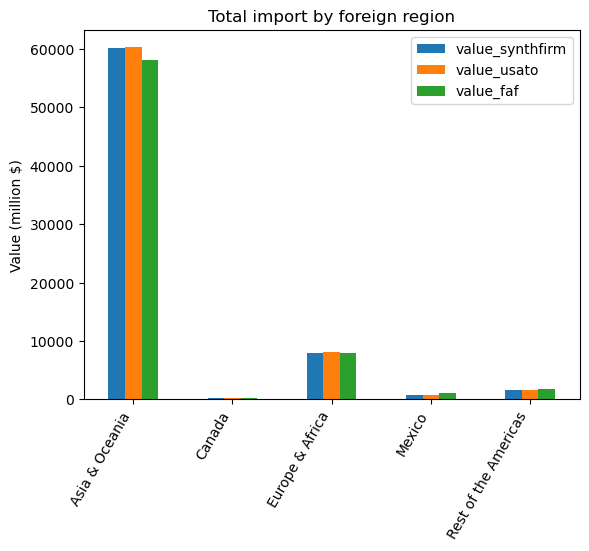

In [6]:
# region total
# Compare import by foreign region
usato_import_by_cfs = \
port_level_import.groupby('CFS_NAME')[['Customs Value (Gen) ($US)']].sum()
usato_import_by_cfs = usato_import_by_cfs.reset_index()

usato_import_by_cfs['Customs Value (Gen) ($US)'] /= 10 ** 6
usato_import_by_cfs.columns = ['CFS_NAME', 'value_usato']
faf_import_agg = \
regional_import.groupby('CFS_NAME')[['value_2017']].sum()
faf_import_agg = faf_import_agg.reset_index()
faf_import_agg.columns = ['CFS_NAME', 'value_faf']

modeled_import_by_cfs = \
import_shipment_value.groupby(['CFS_NAME'])[['value_2017']].sum()

modeled_import_by_cfs = modeled_import_by_cfs.reset_index()
modeled_import_by_cfs.columns = ['CFS_NAME', 'value_synthfirm']
import_value_compare = pd.merge(modeled_import_by_cfs,
                               usato_import_by_cfs, on = 'CFS_NAME',
                               how = 'left')

import_value_compare = pd.merge(import_value_compare,
                               faf_import_agg, on = 'CFS_NAME',
                               how = 'left')
# import_value_compare = import_value_compare.drop(columns = ['dms_orig'])
import_value_compare.plot(x = 'CFS_NAME', kind = 'bar')
plt.title('Total import by foreign region')
plt.ylabel('Value (million $)')
plt.xlabel('')
plt.xticks(rotation = 60, ha = 'right')
plt.savefig(os.path.join(file_path, path_to_plot, 'import_by_foreign_region.png'),
           dpi = 300, bbox_inches = 'tight')

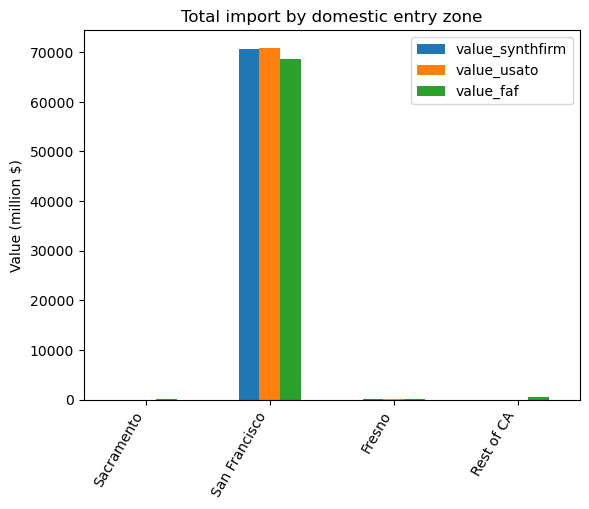

In [7]:
# Compare import by domestic entry
usato_import_by_faf = \
port_level_import.groupby('FAF')[['Customs Value (Gen) ($US)']].sum()
usato_import_by_faf = usato_import_by_faf.reset_index()

usato_import_by_faf['Customs Value (Gen) ($US)'] /= 10 ** 6
usato_import_by_faf.columns = ['dms_orig', 'value_usato']
faf_import_agg = \
regional_import.groupby('dms_orig')[['value_2017']].sum()
faf_import_agg = faf_import_agg.reset_index()
faf_import_agg.columns = ['dms_orig', 'value_faf']

modeled_import_by_faf = \
import_shipment_value.groupby(['FAF', 'SHORTNAME'])[['value_2017']].sum()

modeled_import_by_faf = modeled_import_by_faf.reset_index()
modeled_import_by_faf.columns = ['dms_orig', 'region_name', 'value_synthfirm']
import_value_compare = pd.merge(modeled_import_by_faf,
                               usato_import_by_faf, on = 'dms_orig',
                               how = 'left')

import_value_compare = pd.merge(import_value_compare,
                               faf_import_agg, on = 'dms_orig',
                               how = 'left')
import_value_compare = import_value_compare.drop(columns = ['dms_orig'])
import_value_compare.plot(x = 'region_name', kind = 'bar')
plt.title('Total import by domestic entry zone')
plt.ylabel('Value (million $)')
plt.xlabel('')
plt.xticks(rotation = 60, ha = 'right')
plt.savefig(os.path.join(file_path, path_to_plot, 'import_by_domestic_entry.png'),
           dpi = 300, bbox_inches = 'tight')

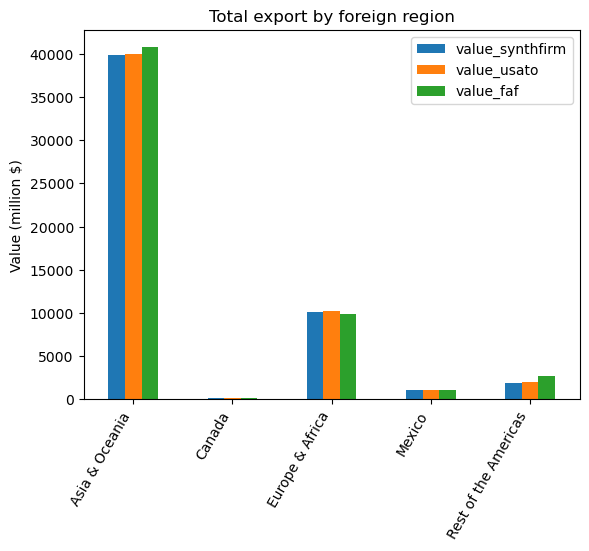

In [8]:
# Compare export by foreign region
usato_export_by_cfs = \
port_level_export.groupby('CFS_NAME')[['Total Exports Value ($US)']].sum()
usato_export_by_cfs = usato_export_by_cfs.reset_index()

usato_export_by_cfs['Total Exports Value ($US)'] /= 10 ** 6
usato_export_by_cfs.columns = ['CFS_NAME', 'value_usato']
faf_export_agg = \
regional_export.groupby('CFS_NAME')[['value_2017']].sum()
faf_export_agg = faf_export_agg.reset_index()
faf_export_agg.columns = ['CFS_NAME', 'value_faf']

modeled_export_by_cfs = \
export_shipment_value.groupby(['CFS_NAME'])[['value_2017']].sum()

modeled_export_by_cfs = modeled_export_by_cfs.reset_index()
modeled_export_by_cfs.columns = ['CFS_NAME', 'value_synthfirm']
export_value_compare = pd.merge(modeled_export_by_cfs,
                               usato_export_by_cfs, on = 'CFS_NAME',
                               how = 'left')

export_value_compare = pd.merge(export_value_compare,
                               faf_export_agg, on = 'CFS_NAME',
                               how = 'left')

export_value_compare.plot(x = 'CFS_NAME', kind = 'bar')
plt.title('Total export by foreign region')
plt.ylabel('Value (million $)')
plt.xlabel('')
plt.xticks(rotation = 60, ha = 'right')
plt.savefig(os.path.join(file_path, path_to_plot, 'export_by_foreign_region.png'),
           dpi = 300, bbox_inches = 'tight')

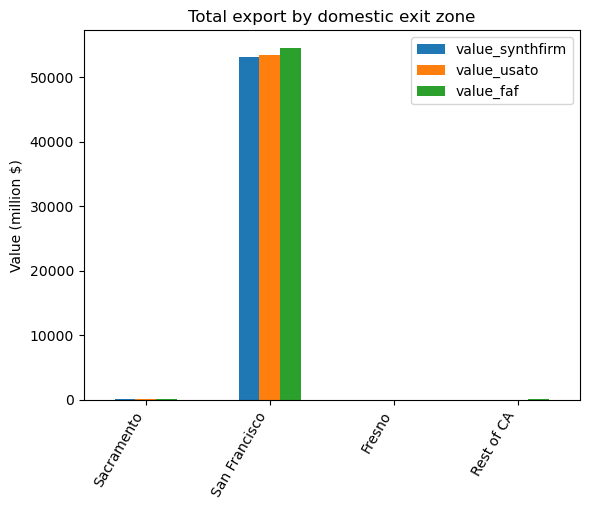

In [9]:
# Compare export by domestic exit
usato_export_by_faf = \
port_level_export.groupby('FAF')[['Total Exports Value ($US)']].sum()
usato_export_by_faf = usato_export_by_faf.reset_index()

usato_export_by_faf['Total Exports Value ($US)'] /= 10 ** 6
usato_export_by_faf.columns = ['dms_dest', 'value_usato']
faf_export_agg = \
regional_export.groupby('dms_dest')[['value_2017']].sum()
faf_export_agg = faf_export_agg.reset_index()
faf_export_agg.columns = ['dms_dest', 'value_faf']

modeled_export_by_faf = \
export_shipment_value.groupby(['FAF', 'SHORTNAME'])[['value_2017']].sum()

modeled_export_by_faf = modeled_export_by_faf.reset_index()
modeled_export_by_faf.columns = ['dms_dest', 'region_name', 'value_synthfirm']
export_value_compare = pd.merge(modeled_export_by_faf,
                               usato_export_by_faf, on = 'dms_dest',
                               how = 'left')

export_value_compare = pd.merge(export_value_compare,
                               faf_export_agg, on = 'dms_dest',
                               how = 'left')
export_value_compare = export_value_compare.drop(columns = ['dms_dest'])
export_value_compare.plot(x = 'region_name', kind = 'bar')
plt.title('Total export by domestic exit zone')
plt.ylabel('Value (million $)')
plt.xlabel('')
plt.xticks(rotation = 60, ha = 'right')
plt.savefig(os.path.join(file_path, path_to_plot, 'export_by_domestic_exit.png'),
           dpi = 300, bbox_inches = 'tight')

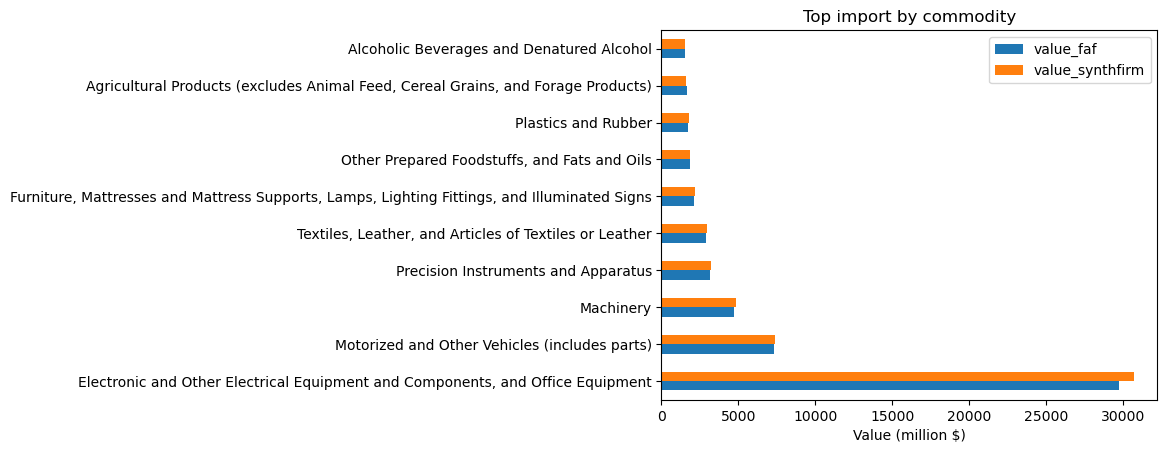

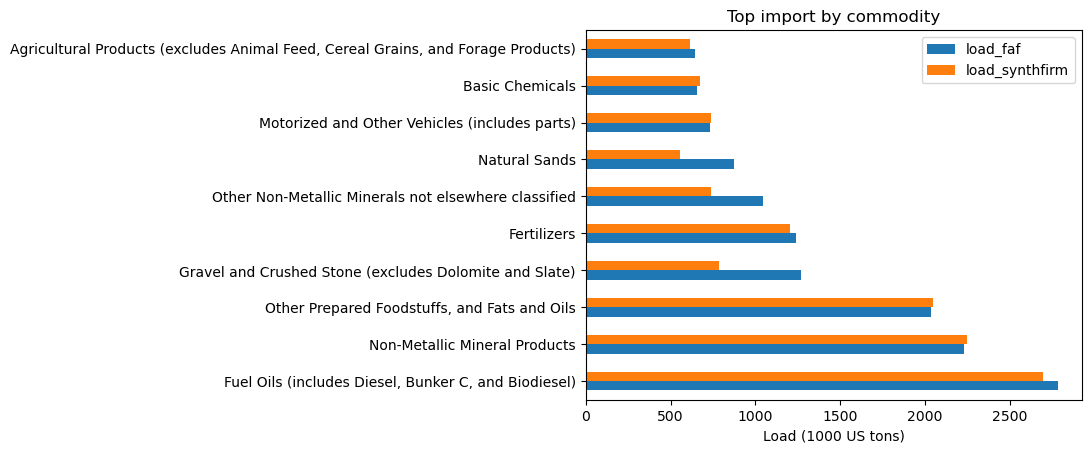

In [10]:
# top 10 import commodity by value and weight

faf_import_by_sctg = \
regional_import.groupby('sctg2')[['value_2017', 'tons_2017']].sum()
faf_import_by_sctg = faf_import_by_sctg.reset_index()
faf_import_by_sctg.columns = ['SCTG_Code', 'value_faf', 'load_faf']

modeled_import_by_sctg = \
import_shipment_value.groupby(['SCTG_Code', 'Description'])[['value_2017',  'total_load']].sum()

modeled_import_by_sctg = modeled_import_by_sctg.reset_index()
modeled_import_by_sctg.columns = ['SCTG_Code', 'commodity', 
                                  'value_synthfirm', 'load_synthfirm']
import_value_compare = pd.merge(faf_import_by_sctg,
                               modeled_import_by_sctg, on = 'SCTG_Code',
                               how = 'left')

import_value_compare = import_value_compare.drop(columns = ['SCTG_Code'])

# plot value
import_value_compare = \
import_value_compare.sort_values(by = 'value_faf', ascending = False)
import_value_to_plot = import_value_compare.head(10)
import_value_to_plot = \
import_value_to_plot[['commodity', 'value_faf', 'value_synthfirm']]
import_value_to_plot.plot(x = 'commodity', kind = 'barh')
plt.title('Top import by commodity')
plt.xlabel('Value (million $)')
plt.ylabel('')
# plt.xticks(rotation = 60, ha = 'right')
plt.savefig(os.path.join(file_path, path_to_plot, 'top_import_by_sctg_value.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

# plot load
import_value_compare = \
import_value_compare.sort_values(by = 'load_faf', ascending = False)
import_load_to_plot = import_value_compare.head(10)
import_load_to_plot = \
import_load_to_plot[['commodity', 'load_faf', 'load_synthfirm']]
import_load_to_plot.plot(x = 'commodity', kind = 'barh')
plt.title('Top import by commodity')
plt.xlabel('Load (1000 US tons)')
plt.ylabel('')
# plt.xticks(rotation = 60, ha = 'right')
plt.savefig(os.path.join(file_path, path_to_plot, 'top_import_by_sctg_load.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

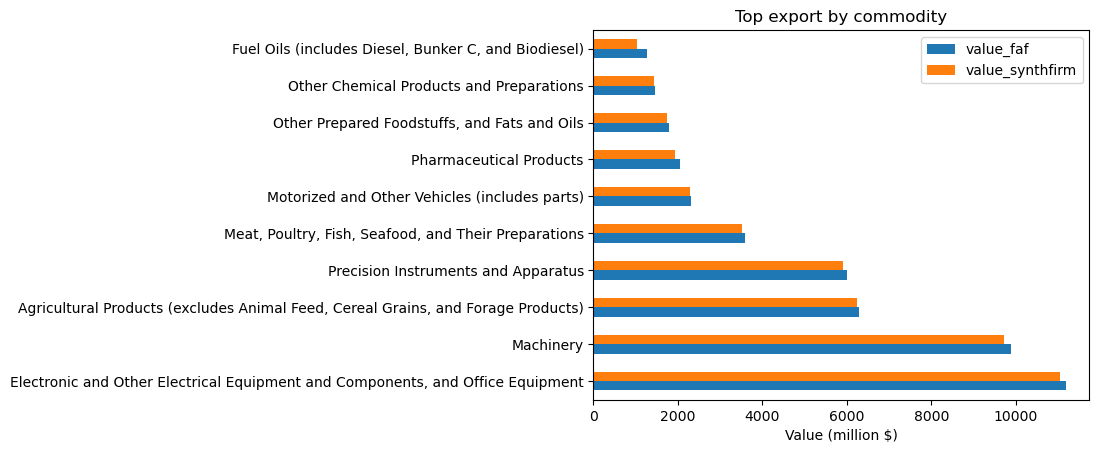

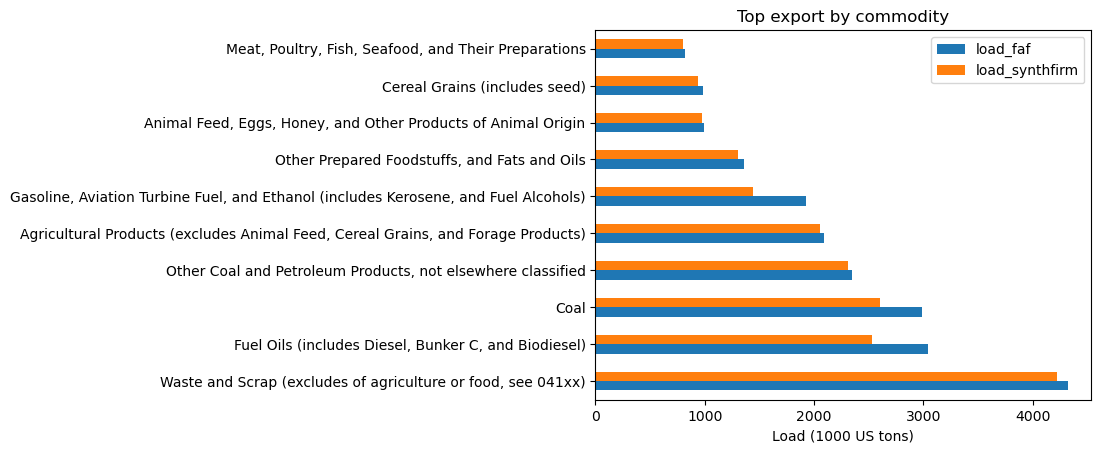

In [11]:
# top 10 export commodity by value and weight

faf_export_by_sctg = \
regional_export.groupby('sctg2')[['value_2017', 'tons_2017']].sum()
faf_export_by_sctg = faf_export_by_sctg.reset_index()
faf_export_by_sctg.columns = ['SCTG_Code', 'value_faf', 'load_faf']

modeled_export_by_sctg = \
export_shipment_value.groupby(['SCTG_Code', 'Description'])[['value_2017',  'total_load']].sum()

modeled_export_by_sctg = modeled_export_by_sctg.reset_index()
modeled_export_by_sctg.columns = ['SCTG_Code', 'commodity', 
                                  'value_synthfirm', 'load_synthfirm']
export_value_compare = pd.merge(faf_export_by_sctg,
                               modeled_export_by_sctg, on = 'SCTG_Code',
                               how = 'left')

export_value_compare = export_value_compare.drop(columns = ['SCTG_Code'])

# plot value
export_value_compare = \
export_value_compare.sort_values(by = 'value_faf', ascending = False)
export_value_to_plot = export_value_compare.head(10)
export_value_to_plot = \
export_value_to_plot[['commodity', 'value_faf', 'value_synthfirm']]
export_value_to_plot.plot(x = 'commodity', kind = 'barh')
plt.title('Top export by commodity')
plt.xlabel('Value (million $)')
plt.ylabel('')
# plt.xticks(rotation = 60, ha = 'right')
plt.savefig(os.path.join(file_path, path_to_plot, 'top_export_by_sctg_value.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

# plot load
export_value_compare = \
export_value_compare.sort_values(by = 'load_faf', ascending = False)
export_load_to_plot = export_value_compare.head(10)
export_load_to_plot = \
export_load_to_plot[['commodity', 'load_faf', 'load_synthfirm']]
export_load_to_plot.plot(x = 'commodity', kind = 'barh')
plt.title('Top export by commodity')
plt.xlabel('Load (1000 US tons)')
plt.ylabel('')
# plt.xticks(rotation = 60, ha = 'right')
plt.savefig(os.path.join(file_path, path_to_plot, 'top_export_by_sctg_load.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

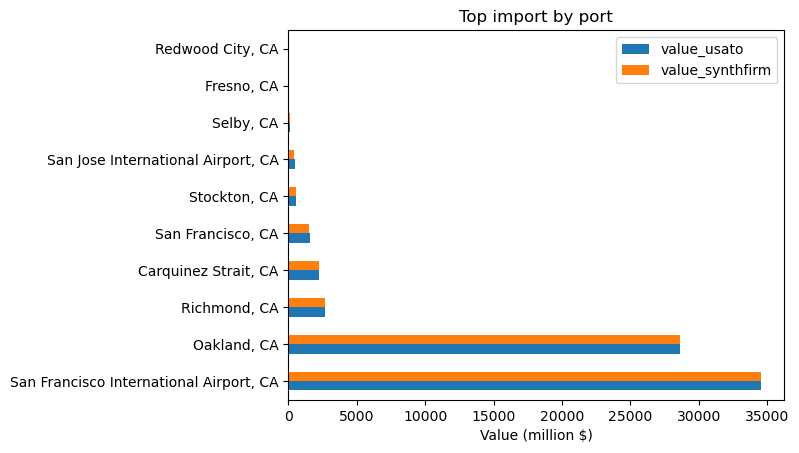

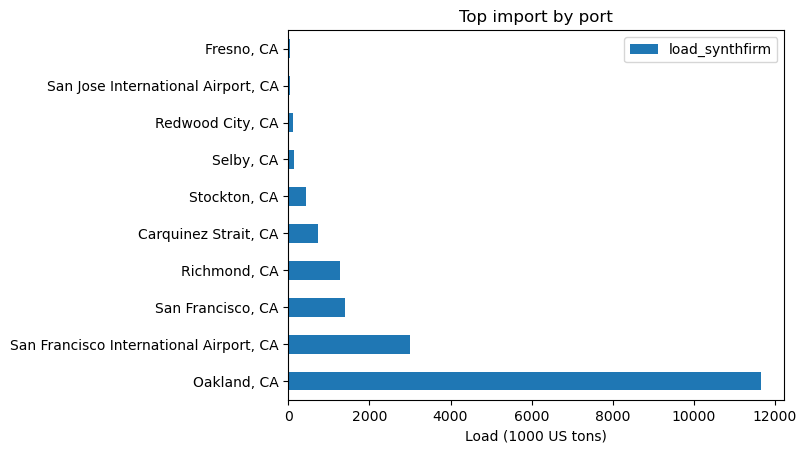

In [14]:
# top 10 import port by value and weight

usato_import_by_port = \
port_level_import.groupby('PORTID')[['Customs Value (Gen) ($US)']].sum()
usato_import_by_port = usato_import_by_port.reset_index()
usato_import_by_port['Customs Value (Gen) ($US)'] /= 10 ** 6 # convert to million
usato_import_by_port.columns = ['PORTID', 'value_usato']

modeled_import_by_port = \
import_shipment_value.groupby(['PORTID'])[['value_2017', 'total_load']].sum()

modeled_import_by_port = modeled_import_by_port.reset_index()
modeled_import_by_port.columns = ['PORTID', 
                                  'value_synthfirm', 'load_synthfirm']
import_value_compare = pd.merge(usato_import_by_port,
                               modeled_import_by_port, on = 'PORTID',
                               how = 'left')

# plot value
import_value_compare = \
import_value_compare.sort_values(by = 'value_usato', ascending = False)
import_value_to_plot = import_value_compare.head(10)
import_value_to_plot = \
import_value_to_plot[['PORTID', 'value_usato', 'value_synthfirm']]
import_value_to_plot.plot(x = 'PORTID', kind = 'barh')
plt.title('Top import by port')
plt.xlabel('Value (million $)')
plt.ylabel('')
# plt.xticks(rotation = 60, ha = 'right')
plt.savefig(os.path.join(file_path, path_to_plot, 'top_import_by_port_value.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

# plot load
import_value_compare = \
import_value_compare.sort_values(by = 'load_synthfirm', ascending = False)
import_load_to_plot = import_value_compare.head(10)
import_load_to_plot = \
import_load_to_plot[['PORTID', 'load_synthfirm']]
import_load_to_plot.plot(x = 'PORTID', kind = 'barh')
plt.title('Top import by port')
plt.xlabel('Load (1000 US tons)')
plt.ylabel('')
# plt.xticks(rotation = 60, ha = 'right')
plt.savefig(os.path.join(file_path, path_to_plot, 'top_import_by_port_load.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

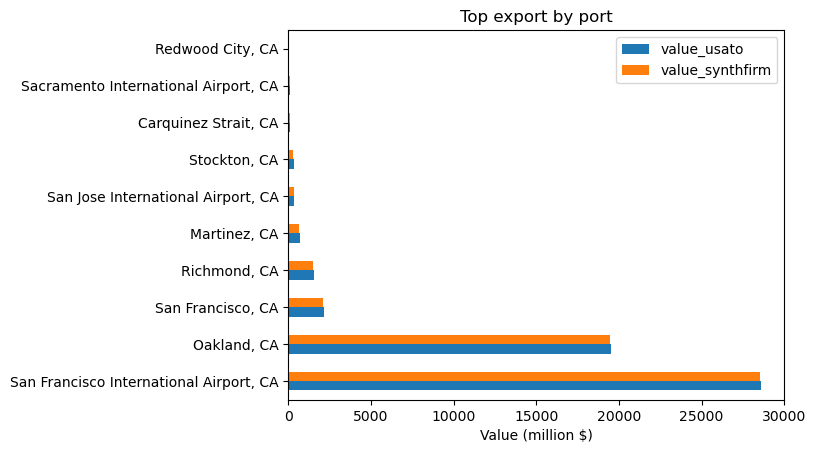

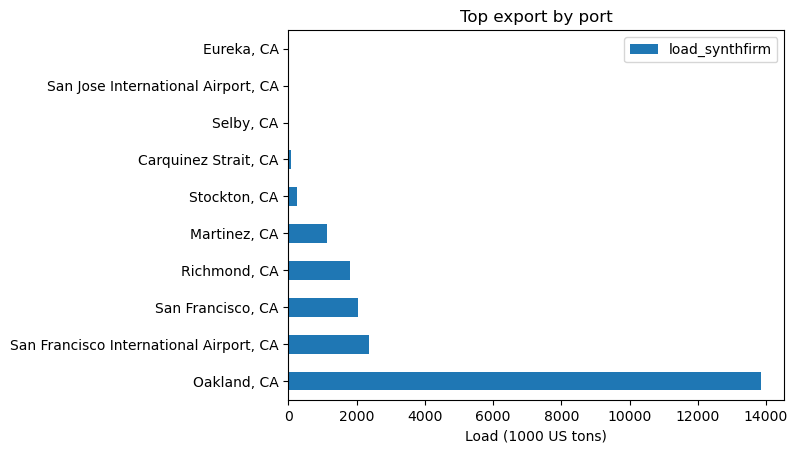

In [15]:
# top 10 export port by value and weight

usato_export_by_port = \
port_level_export.groupby('PORTID')[['Total Exports Value ($US)']].sum()
usato_export_by_port = usato_export_by_port.reset_index()
usato_export_by_port['Total Exports Value ($US)'] /= 10 ** 6 # convert to million
usato_export_by_port.columns = ['PORTID', 'value_usato']

modeled_export_by_port = \
export_shipment_value.groupby(['PORTID'])[['value_2017', 'total_load']].sum()

modeled_export_by_port = modeled_export_by_port.reset_index()
modeled_export_by_port.columns = ['PORTID', 
                                  'value_synthfirm', 'load_synthfirm']
export_value_compare = pd.merge(usato_export_by_port,
                               modeled_export_by_port, on = 'PORTID',
                               how = 'left')

# plot value
export_value_compare = \
export_value_compare.sort_values(by = 'value_usato', ascending = False)
export_value_to_plot = export_value_compare.head(10)
export_value_to_plot = \
export_value_to_plot[['PORTID', 'value_usato', 'value_synthfirm']]
export_value_to_plot.plot(x = 'PORTID', kind = 'barh')
plt.title('Top export by port')
plt.xlabel('Value (million $)')
plt.ylabel('')
# plt.xticks(rotation = 60, ha = 'right')
plt.savefig(os.path.join(file_path, path_to_plot, 'top_export_by_port_value.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

# plot load
export_value_compare = \
export_value_compare.sort_values(by = 'load_synthfirm', ascending = False)
export_load_to_plot = export_value_compare.head(10)
export_load_to_plot = \
export_load_to_plot[['PORTID', 'load_synthfirm']]
export_load_to_plot.plot(x = 'PORTID', kind = 'barh')
plt.title('Top export by port')
plt.xlabel('Load (1000 US tons)')
plt.ylabel('')
# plt.xticks(rotation = 60, ha = 'right')
plt.savefig(os.path.join(file_path, path_to_plot, 'top_export_by_port_load.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

# Part 2 -- port of SF and OAK characteristics

In [6]:
# check results for SFO and OAK

port_list = ['Oakland, CA', 'San Francisco, CA']
sf_export_truck_shipment = \
export_truck_shipment.loc[export_truck_shipment['PORTID'].isin(port_list)]

sf_import_truck_shipment = \
import_truck_shipment.loc[import_truck_shipment['PORTID'].isin(port_list)]

sf_import_truck_shipment.head(5)

,PORTID,CBP Port Location,FAF,CBPZONE,PORTZONE,TYPE,is_airport,CFS_CODE,CFS_NAME,dms_dest,...,BuyerID,BuyerZone,BuyerNAICS,veh_type,SHORTNAME,MESOZONE,FAFNAME,total_load,SCTG_Code,Description
96326,"Oakland, CA","Oakland, CA (Port)",64,6001,1044.0,Port,0,A,Asia & Oceania,11,...,3565532.0,20001.0,541300,Diesel Class 7&8 Tractor,San Francisco,20001.0,Birmingham,0.054199,20,Basic Chemicals
96327,"Oakland, CA","Oakland, CA (Port)",64,6001,1044.0,Port,0,A,Asia & Oceania,11,...,3214766.0,20001.0,532100,Diesel Class 7&8 Tractor,San Francisco,20001.0,Birmingham,0.017468,24,Plastics and Rubber
96328,"Oakland, CA","Oakland, CA (Port)",64,6001,1044.0,Port,0,A,Asia & Oceania,11,...,6312603.0,20001.0,813100,Diesel Class 7&8 Tractor,San Francisco,20001.0,Birmingham,0.008226,30,"Textiles, Leather, and Articles of Textiles or..."
96329,"Oakland, CA","Oakland, CA (Port)",64,6001,1044.0,Port,0,A,Asia & Oceania,11,...,5526671.0,20001.0,722110,Diesel Class 7&8 Tractor,San Francisco,20001.0,Birmingham,0.005756,31,Non-Metallic Mineral Products
96330,"Oakland, CA","Oakland, CA (Port)",64,6001,1044.0,Port,0,A,Asia & Oceania,11,...,8214898.0,20001.0,491000,Diesel Class 7&8 Tractor,San Francisco,20001.0,Birmingham,0.785837,33,Articles of Base Metal


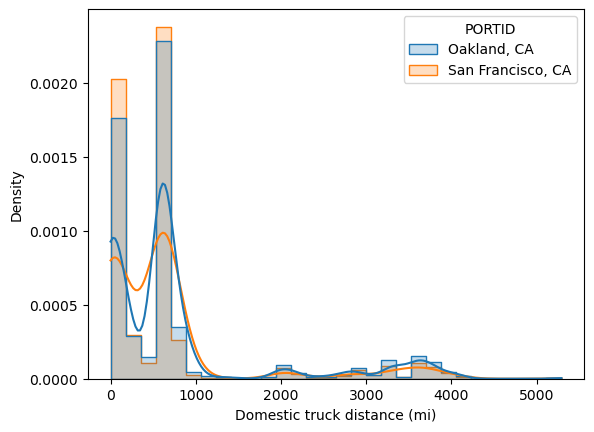

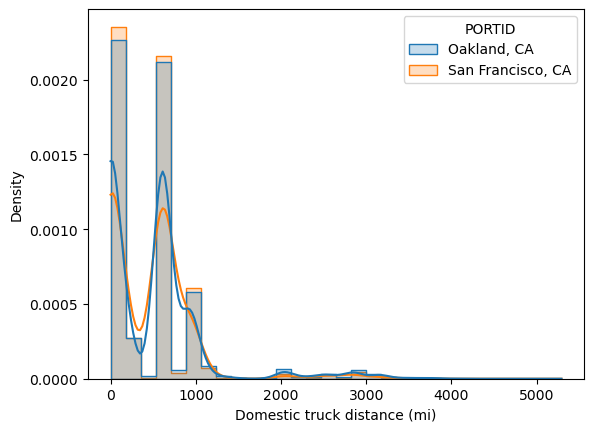

In [17]:
# plot shipment distance
sns.histplot(
   data=sf_import_truck_shipment, x="Distance", hue="PORTID", weights = 'total_load',
   common_norm=False, kde=True, element="step", bins = 30, stat = 'density',
)
plt.xlabel('Domestic truck distance (mi)')
plt.savefig(os.path.join(file_path, path_to_plot, 'import_by_port_dist.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

sns.histplot(
   data=sf_export_truck_shipment, x="Distance", hue="PORTID", weights = 'total_load',
   common_norm=False, kde=True, element="step", bins = 30, stat = 'density',
)
plt.xlabel('Domestic truck distance (mi)')
plt.savefig(os.path.join(file_path, path_to_plot, 'export_by_port_dist.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

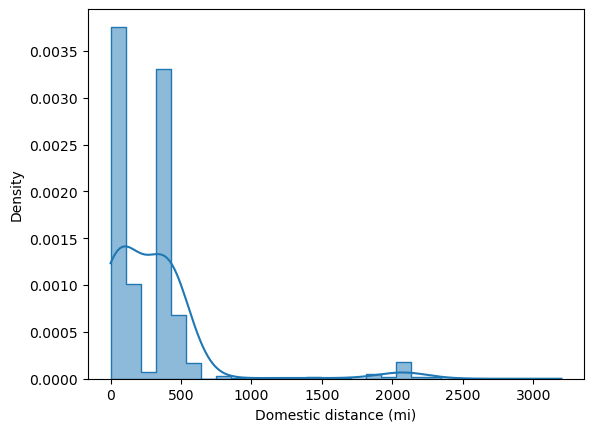

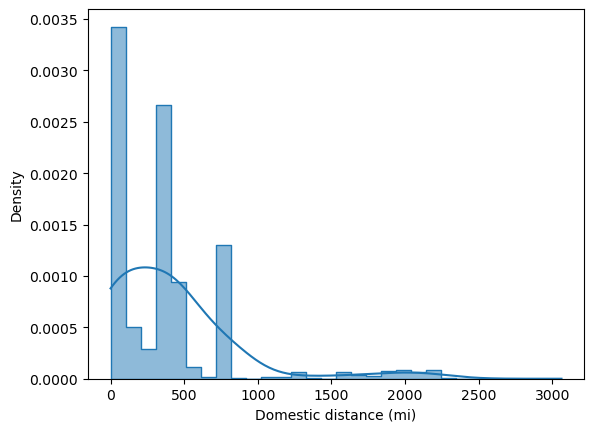

In [20]:
# plot reference shipment distance from faf
regional_import_truck = \
regional_import.loc[regional_import['mode_def'] == 'Truck']
sns.histplot(
   data=regional_import_truck, x="distance", weights = 'tons_2017',
   common_norm=False, kde=True, element="step", bins = 30, stat = 'density',
)
plt.xlabel('Domestic distance (mi)')
plt.savefig(os.path.join(file_path, path_to_plot, 'import_faf_dist.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

regional_export_truck = \
regional_export.loc[regional_export['mode_def'] == 'Truck']
sns.histplot(
   data=regional_export_truck, x="distance", weights = 'tons_2017',
   common_norm=False, kde=True, element="step", bins = 30, stat = 'density',
)
plt.xlabel('Domestic distance (mi)')
plt.savefig(os.path.join(file_path, path_to_plot, 'export_faf_dist.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

In [18]:
regional_import.columns

Index(['fr_orig', 'dms_orig', 'dms_dest', 'fr_dest', 'fr_inmode', 'dms_mode',
       'fr_outmode', 'sctg2', 'trade_type', 'dist_band', 'tons_2017',
       'value_2017', 'tmiles_2017', 'CFS_CODE', 'CFS_NAME', 'distance',
       'mode_def'],
      dtype='object')

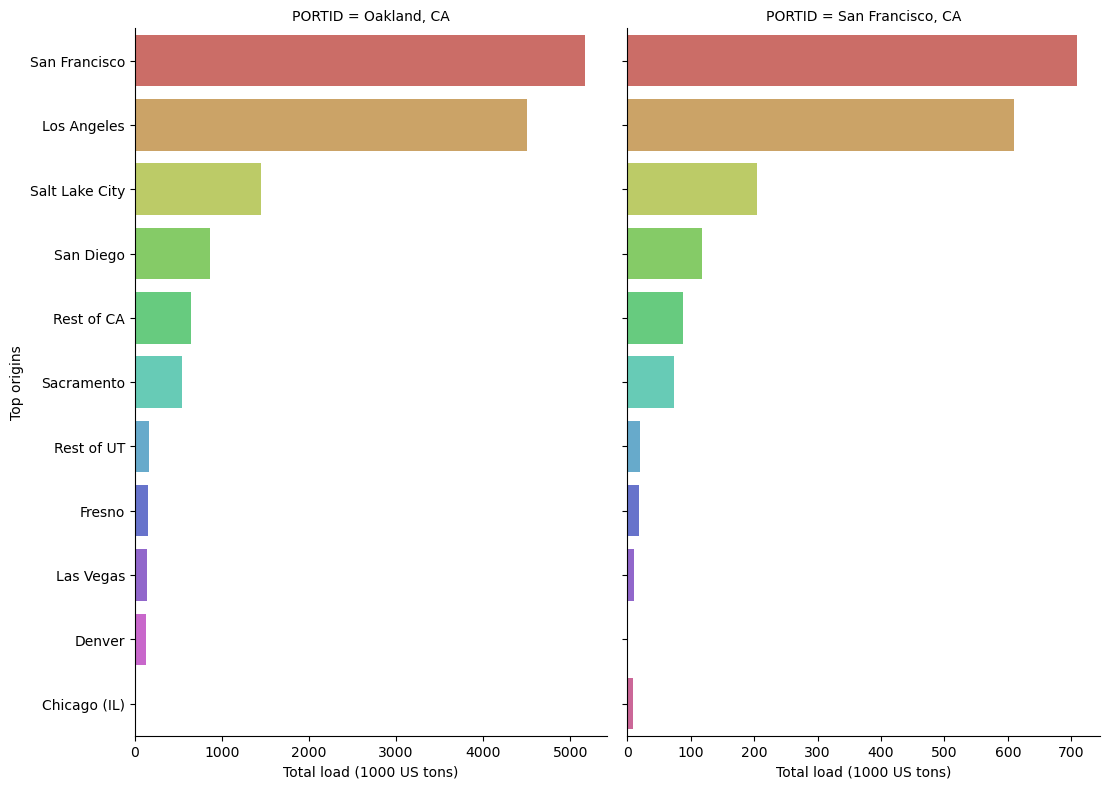

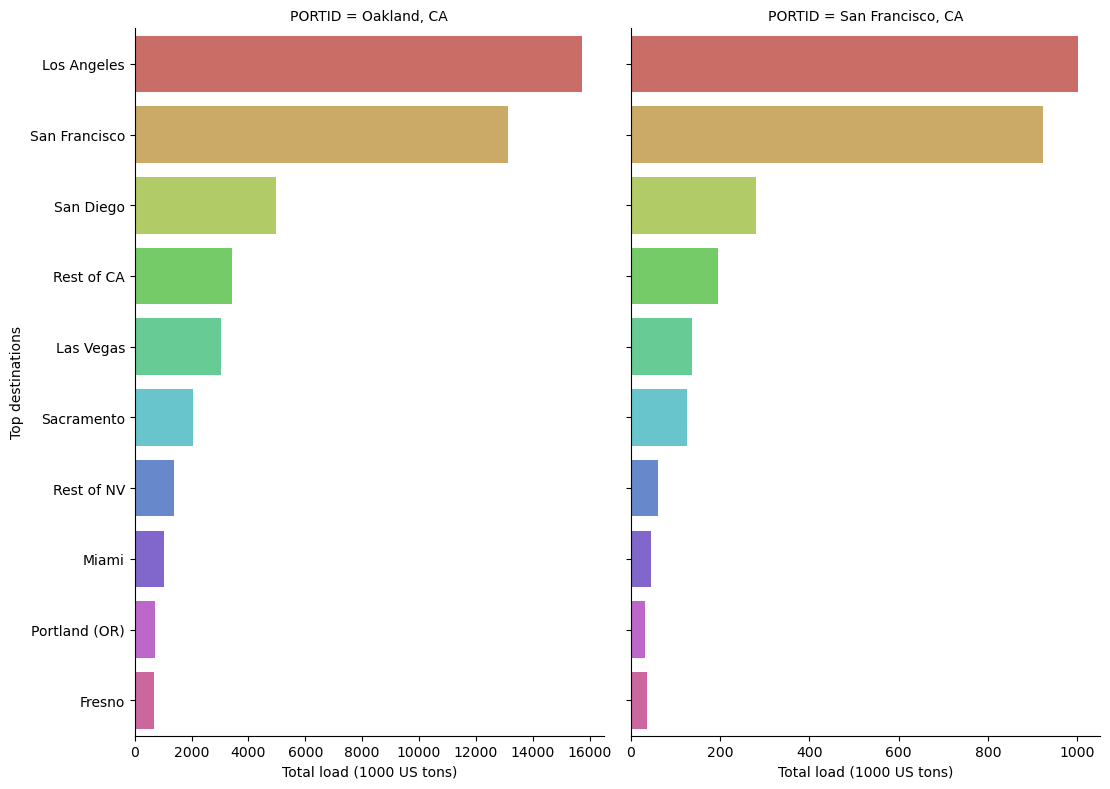

In [45]:
# top origin/destination
sf_export_truck_origin = \
sf_export_truck_shipment.groupby(['PORTID', 'FAFNAME'])[['total_load']].sum()
sf_export_truck_origin = sf_export_truck_origin.reset_index()
sf_export_truck_origin = \
sf_export_truck_origin.sort_values(by = 'total_load', ascending = False)

sf_import_truck_dest = \
sf_import_truck_shipment.groupby(['PORTID', 'FAFNAME'])[['total_load']].sum()
sf_import_truck_dest = sf_import_truck_dest.reset_index()
sf_import_truck_dest = \
sf_import_truck_dest.sort_values(by = 'total_load', ascending = False)

sf_import_truck_dest.head(5)

sf_export_truck_origin = sf_export_truck_origin.groupby('PORTID').head(10)
sf_export_truck_origin = sf_export_truck_origin.reset_index()

ax = sns.catplot(kind = 'bar', data = sf_export_truck_origin,
           y = 'FAFNAME', x = 'total_load', col = 'PORTID', sharex = False,
                 height=8, aspect = 0.7, palette = 'hls')
ax.set(ylabel ="Top origins")
ax.set(xlabel ="Total load (1000 US tons)")
plt.savefig(os.path.join(file_path, path_to_plot, 'export_by_port_orig.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()
sf_import_truck_dest = sf_import_truck_dest.groupby('PORTID').head(10)
sf_import_truck_dest = sf_import_truck_dest.reset_index()

ax = sns.catplot(kind = 'bar', data = sf_import_truck_dest,
           y = 'FAFNAME', x = 'total_load', col = 'PORTID', sharex = False,
                 height=8, aspect = 0.7, palette = 'hls')
ax.set(ylabel ="Top destinations")
ax.set(xlabel ="Total load (1000 US tons)")
plt.savefig(os.path.join(file_path, path_to_plot, 'import_by_port_dest.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

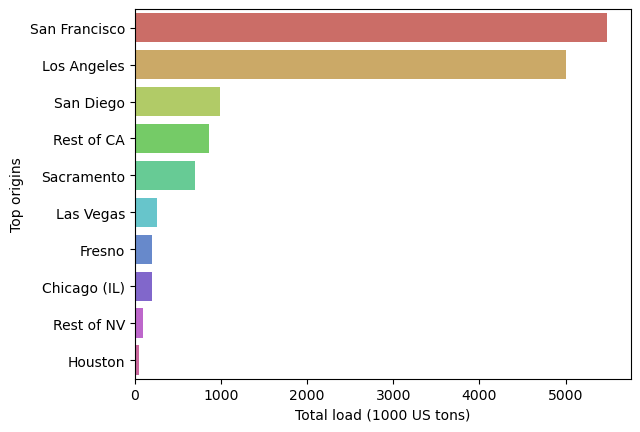

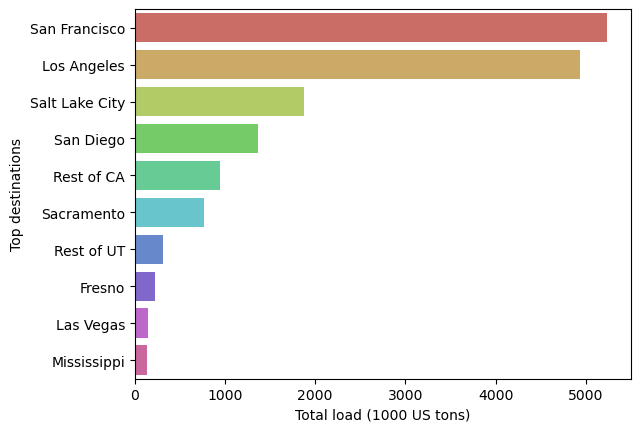

In [33]:
# plot reference faf top origin/destinations
faf_name_lookup['FAF'] = faf_name_lookup['FAF'].astype(int)
faf_export_truck_origin = \
regional_import_truck.groupby(['dms_dest'])[['tons_2017']].sum()
faf_export_truck_origin = faf_export_truck_origin.reset_index()
faf_export_truck_origin = pd.merge(faf_export_truck_origin, 
                                   faf_name_lookup,
                                   left_on = 'dms_dest', right_on = 'FAF',
                                   how = 'left')
faf_export_truck_origin = \
faf_export_truck_origin.sort_values(by = 'tons_2017', ascending = False)

faf_import_truck_dest = \
regional_export_truck.groupby(['dms_orig'])[['tons_2017']].sum()
faf_import_truck_dest = faf_import_truck_dest.reset_index()
faf_import_truck_dest = pd.merge(faf_import_truck_dest, 
                                   faf_name_lookup,
                                   left_on = 'dms_orig', right_on = 'FAF',
                                   how = 'left')
faf_import_truck_dest = \
faf_import_truck_dest.sort_values(by = 'tons_2017', ascending = False)

sf_import_truck_dest.head(5)

faf_export_truck_origin = faf_export_truck_origin.head(10)

ax = sns.barplot(data = faf_export_truck_origin,
           y = 'SHORTNAME', x = 'tons_2017',
           palette = 'hls')
ax.set(ylabel ="Top origins")
ax.set(xlabel ="Total load (1000 US tons)")
plt.savefig(os.path.join(file_path, path_to_plot, 'export_faf_orig.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

faf_import_truck_dest = faf_import_truck_dest.head(10)
ax = sns.barplot( data = faf_import_truck_dest,
           y = 'SHORTNAME', x = 'tons_2017',
            palette = 'hls')
ax.set(ylabel ="Top destinations")
ax.set(xlabel ="Total load (1000 US tons)")
plt.savefig(os.path.join(file_path, path_to_plot, 'import_faf_dest.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

In [21]:
faf_name_lookup.head(5)

,FAF,SHORTNAME
0,11,Birmingham
1,12,Mobile
2,19,Rest of AL
3,20,Alaska
4,41,Phoenix


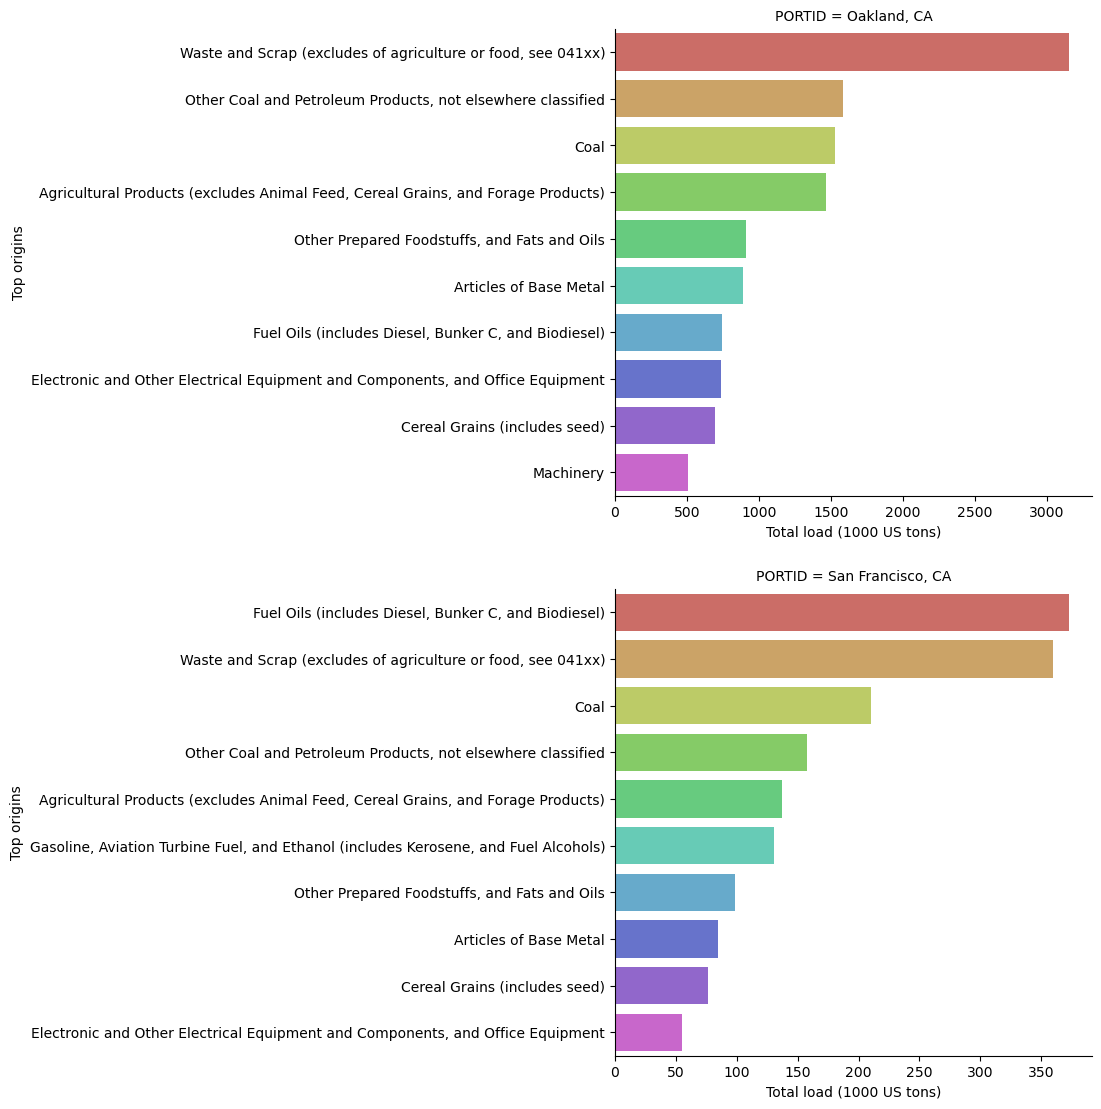

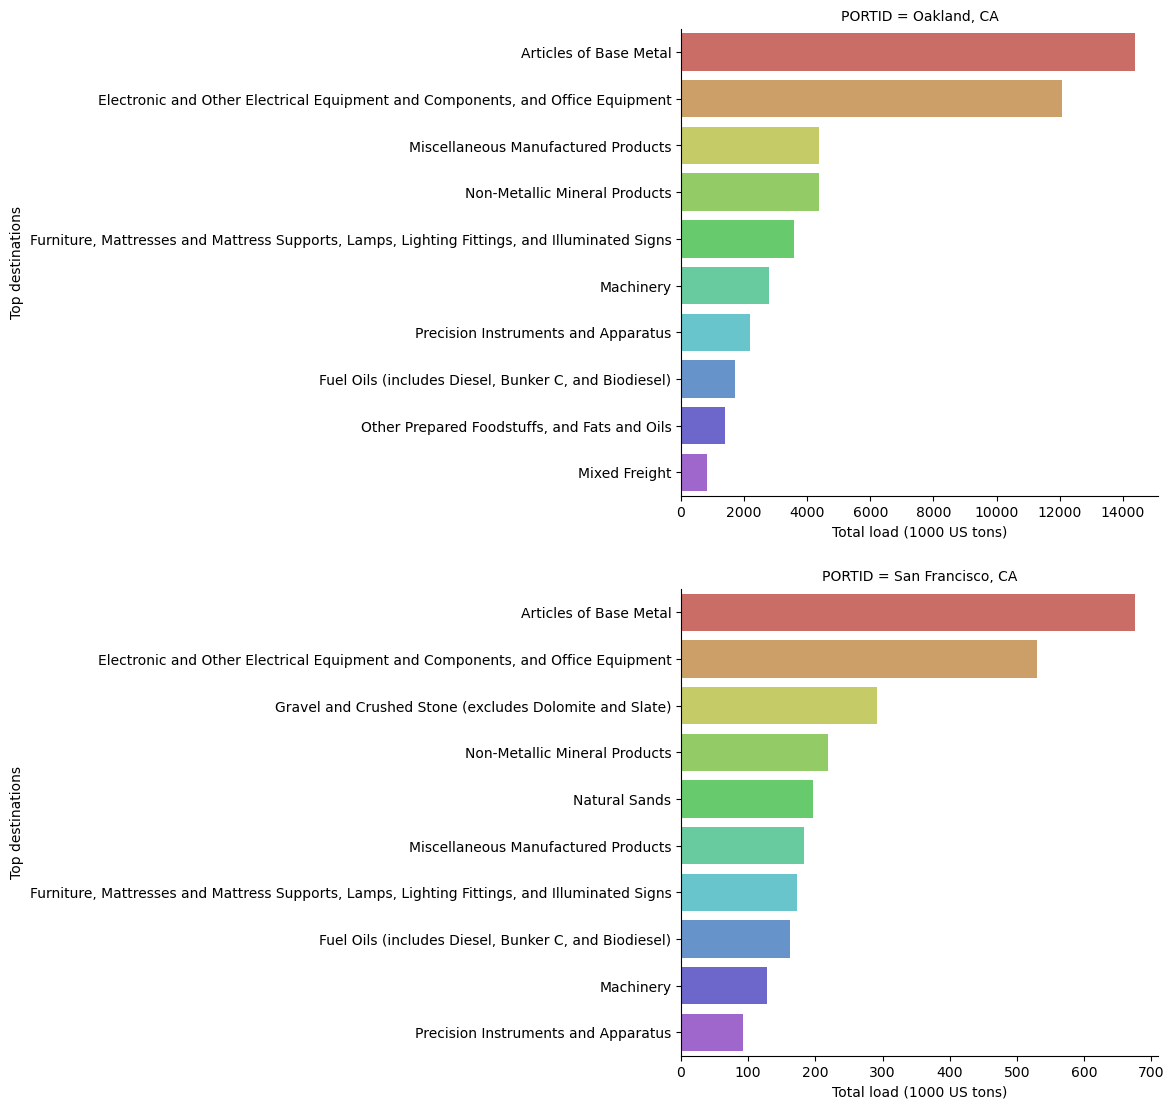

In [44]:
# top import/export commodity
sf_export_truck_sctg = \
sf_export_truck_shipment.groupby(['PORTID', 'Description'])[['total_load']].sum()
sf_export_truck_sctg = sf_export_truck_sctg.reset_index()
sf_export_truck_sctg = \
sf_export_truck_sctg.sort_values(by = 'total_load', ascending = False)

sf_import_truck_sctg = \
sf_import_truck_shipment.groupby(['PORTID', 'Description'])[['total_load']].sum()
sf_import_truck_sctg = sf_import_truck_sctg.reset_index()
sf_import_truck_sctg = \
sf_import_truck_sctg.sort_values(by = 'total_load', ascending = False)

sf_import_truck_sctg.head(5)

sf_export_truck_sctg = sf_export_truck_sctg.groupby('PORTID').head(10)
sf_export_truck_sctg = sf_export_truck_sctg.reset_index()

ax = sns.catplot(kind = 'bar', data = sf_export_truck_sctg,
           y = 'Description', x = 'total_load', row = 'PORTID', sharex = False,
           sharey = False, height=5.5, aspect = 1, palette = 'hls')
ax.set(ylabel ="Top origins")
ax.set(xlabel ="Total load (1000 US tons)")
plt.subplots_adjust(hspace = 0.2)
plt.savefig(os.path.join(file_path, path_to_plot, 'export_by_port_sctg.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

sf_import_truck_sctg = sf_import_truck_sctg.groupby('PORTID').head(10)
sf_import_truck_sctg = sf_import_truck_sctg.reset_index()

ax = sns.catplot(kind = 'bar', data = sf_import_truck_sctg,
           y = 'Description', x = 'total_load', row = 'PORTID', sharex = False,
           sharey = False, height=5.5, aspect = 1, palette = 'hls')
ax.set(ylabel ="Top destinations")
ax.set(xlabel ="Total load (1000 US tons)")
plt.subplots_adjust(hspace = 0.2)
plt.savefig(os.path.join(file_path, path_to_plot, 'import_by_port_sctg.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()